In [85]:
import pandas as pd 
import numpy as np 
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
data_train = pd.read_csv('train.csv',engine = 'python',encoding='UTF-8')
data = pd.read_csv('train.csv',engine = 'python',encoding='UTF-8')


In [2]:
import seaborn as sns

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


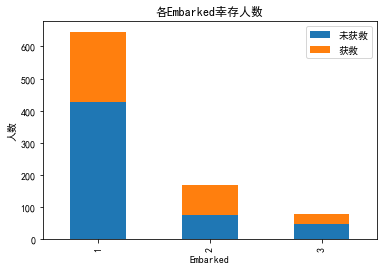

In [320]:
def survivedFactorPlot(data_train,col):
    Survived_0 = data_train[col][data_train.Survived == 0].value_counts()
    Survived_1 = data_train[col][data_train.Survived == 1].value_counts()
    df=pd.DataFrame({u'未获救':Survived_0,u'获救':Survived_1})
    df.plot(kind='bar', stacked=True)
    plt.title(f"各{col}幸存人数")
    plt.xlabel(col) 
    plt.ylabel(u"人数") 
    plt.show()
survivedFactorPlot(data_train,'Embarked')

In [178]:
# data_train.info()
data_train.loc[data_train.Cabin.isnull(),'HasCabin']=0
data_train.loc[data_train.Cabin.notnull(),'HasCabin']=1

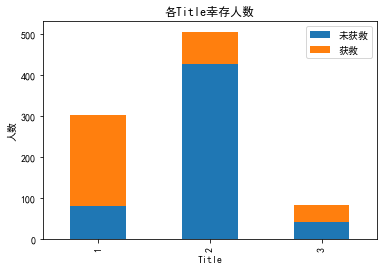

In [217]:
#根据称谓划分，名字长度和是否有括号太玄学了
def splitName(data_train):
    alltitles = data_train.Name.str.extract('([A-Za-z]+)\.')[0].value_counts()
    titles = alltitles.index.tolist()[:4]
    rares = alltitles.index.tolist()[4:]
    for title in titles:
        data_train.loc[data_train.Name.str.contains(title),'Title']=title
    for title in rares:    
        data_train.loc[data_train.Name.str.contains(title),'Title']='Rare'
    return data_train
survivedFactorPlot(data_train,'Title')

In [244]:
#都转成数值一会用来生成Age
def toNum(data_train):
#     data_train.Sex = data.Sex
#     data_train.Embarked = data.Embarked
#     data_train.loc[data_train.Embarked.isnull(),'Embarked']='S'
    # data_train.Title = data.Title
    data_train.loc[data_train.Sex=='male','Sex']=0
    data_train.loc[data_train.Sex=='female','Sex']=1
    data_train.loc[data_train.Embarked=='S','Embarked']=1
    data_train.loc[data_train.Embarked=='C','Embarked']=2
    data_train.loc[data_train.Embarked=='Q','Embarked']=3
    data_train.loc[data_train.Title=='Miss','Title']=1
    data_train.loc[data_train.Title=='Mrs','Title']=1
    data_train.loc[data_train.Title=='Mr','Title']=2
    data_train.loc[data_train.Title=='Master','Title']=3
    data_train.loc[data_train.Title=='Rare','Title']=3
    return data_train

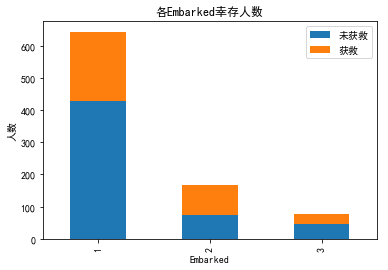

In [172]:
survivedFactorPlot(data_train,'Embarked')

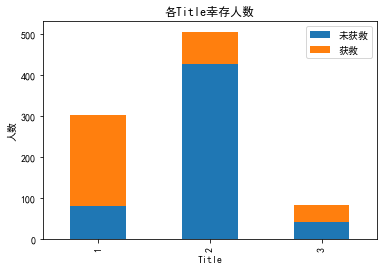

In [156]:
survivedFactorPlot(data_train,'Title')

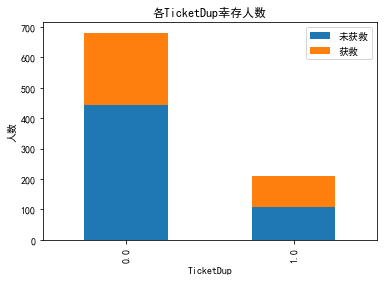

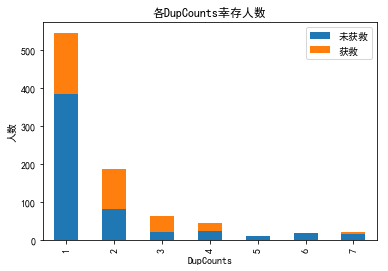

In [109]:
#ticket是否相同可以作为一个特征
data_train.loc[data_train.Ticket.duplicated(),'TicketDup']=1
data_train.loc[data_train.Ticket.duplicated()==False,'TicketDup']=0
survivedFactorPlot(data_train,'TicketDup')
survivedFactorPlot(data_train,'DupCounts')

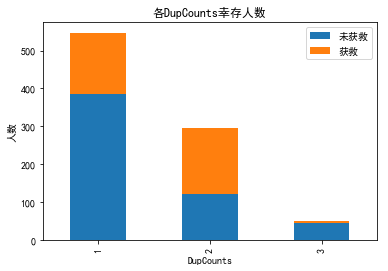

In [248]:
#重复人数也可以作为特征
def dupCount(data_train):
    dup_counts = data_train.groupby('Ticket')['Ticket'].transform('count')
    data_train['DupCounts'] = dup_counts
    data_train.loc[dup_counts==1,'DupCounts'] = 1#一个人是第一类
    data_train.loc[dup_counts>1,'DupCounts'] = 2#2到4个人是第二类
    data_train.loc[dup_counts>=5,'DupCounts'] = 3#更多的是第三类
survivedFactorPlot(data_train,'DupCounts')

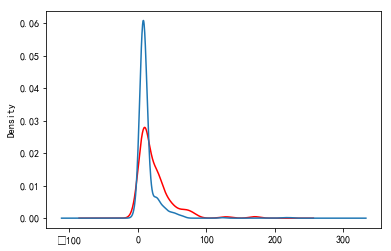

In [163]:
#Fare是相同票人的票价的和，应该除一下
#票价高的力压一头
data_train['Fare_mean'] = data_train.Fare/dup_counts
data_train.Fare_mean[data_train.Survived == 1].plot(kind='kde',color='r')   
data_train.Fare_mean[data_train.Survived == 0].plot(kind='kde')

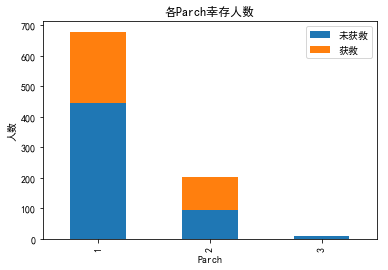

In [135]:
data_train['Parch'] = data['Parch']
parch = data_train.Parch.copy()
data_train.loc[parch==0,'Parch'] = 1
data_train.loc[parch>0,'Parch'] = 2
data_train.loc[parch>=4,'Parch'] = 3 
survivedFactorPlot(data_train,'Parch')

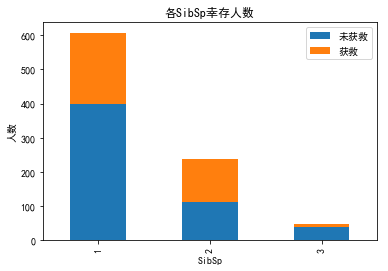

In [140]:
data_train['SibSp'] = data['SibSp']
sib = data_train.SibSp.copy()
data_train.loc[sib==0,'SibSp'] = 1
data_train.loc[sib>0,'SibSp'] = 2
data_train.loc[sib>=3,'SibSp'] = 3 
survivedFactorPlot(data_train,'SibSp')

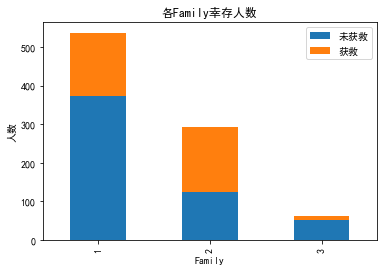

In [149]:
data_train['Family']=data.eval('SibSp+Parch+1')
family = data_train.Family.copy()
data_train.loc[family==1,'Family'] = 1
data_train.loc[family>1,'Family'] = 2
data_train.loc[family>=5,'Family'] = 3 
survivedFactorPlot(data_train,'Family')

In [165]:
# data_train.drop('SibSph', axis=1, inplace=True)
#还有cabin可以改进
#生成Age
#应该先进行one-hot编码还是先进行拟合呢？
from sklearn.ensemble import RandomForestRegressor

def set_missing_ages(df,cols):

    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df[cols]

    # 乘客分成已知年龄和未知年龄两部分
    known_age = age_df[age_df.Age.notnull()].as_matrix()
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()

    # y即目标年龄
    y = known_age[:, 0]

    # X即特征属性值
    X = known_age[:, 1:]

    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)

    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(unknown_age[:, 1::])

    # 用得到的预测结果填补原缺失数据
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 

    return df, rfr


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [194]:
#可能会有问题，因为用了123代表，引入了距离
dummies=['Age','Pclass','SibSp','Parch','Embarked','Title','Sex','TicketDup','DupCounts','HasCabin','Family','Fare_mean']
data_train.to_csv('allpara.csv')

In [311]:
data_dummies = pd.get_dummies(data_train,columns=dummies[1:-1])
data_dummies = data_dummies.drop(['PassengerId','Survived','Name','Ticket','Fare','Cabin'],axis=1)
data_dummies['Age'] = data['Age']
# data_dummies.info()
data_dummies , rfr = set_missing_ages(data_dummies,data_dummies.columns.values.tolist())


In [310]:
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
age_scale_param = scaler.fit(data_dummies['Age'].values.reshape(-1,1))
data_dummies['Age'] = scaler.fit_transform(data_dummies['Age'].values.reshape(-1,1), age_scale_param)
fare_scale_param = scaler.fit(data_dummies['Fare_mean'].values.reshape(-1,1))
data_dummies['Fare_mean'] = scaler.fit_transform(data_dummies['Fare_mean'].values.reshape(-1,1), fare_scale_param)


In [362]:
data_dummies = data_dummies.drop(["SibSp_1","SibSp_2","SibSp_3","Parch_1","Parch_2","Parch_3"],axis=1)

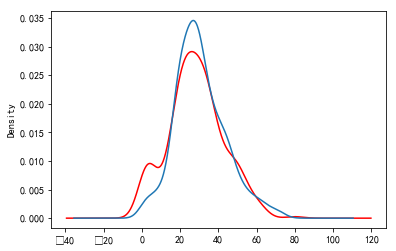

In [300]:
data_dummies.Age[data.Survived == 1].plot(kind='kde',color='r')   
data_dummies.Age[data.Survived == 0].plot(kind='kde')

In [308]:
group_labels = ['baby','child','youth','strong','mid','old']
data_dummies['Age_label'] = pd.cut(data_dummies.Age,[-1,10,18,38,48,58,200],labels=group_labels)

In [315]:
group_labels = ['poor','norm','rich']
data_dummies['Fare_label'] = pd.cut(data_dummies.Fare_mean,[-1,20,100,1000],labels=group_labels)

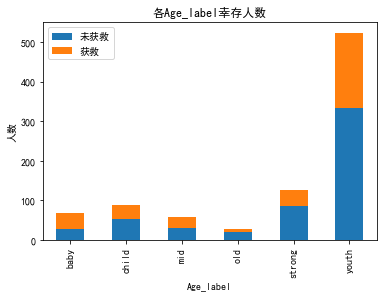

In [322]:
data_dummies['Survived'] = data_train.Survived
survivedFactorPlot(data_dummies,'Age_label')

In [323]:
data_dummies = pd.get_dummies(data_dummies,columns=['Age_label','Fare_label'])

In [325]:
data_dummies = data_dummies.drop(['Age','Fare_mean','Survived'],axis=1)

In [363]:
from sklearn import linear_model

# 用正则取出我们要的属性值
train_np = data_dummies.as_matrix()

# y即第0列：Survival结果
y = np.array(data_train.Survived)

# X即第1列及以后：特征属性值
X = train_np

# fit到LogisticRegression之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
clf.fit(X, y)
sum(clf.predict(X)==y)/X.shape[0]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


0.8327721661054994

In [220]:
#早知道就先把两个数据集合起来操作了。。。
data_test = pd.read_csv("test.csv")

In [246]:
data_test = splitName(data_test)
data_test.Fare[data_test.Fare.isnull()] = (data_test.Fare[data_test.Fare.notnull()].values).mean()
data_test = toNum(data_test)

In [249]:
data_test.loc[data_test.Ticket.duplicated(),'TicketDup']=1
data_test.loc[data_test.Ticket.duplicated()==False,'TicketDup']=0
dupCount(data_test)
sib = data_test.SibSp.copy()
data_test.loc[sib==0,'SibSp'] = 1
data_test.loc[sib>0,'SibSp'] = 2
data_test.loc[sib>=3,'SibSp'] = 3 

In [251]:
data_test1 = pd.read_csv("test.csv")
data_test['Family']=data_test1.eval('SibSp+Parch+1')
family = data_test.Family.copy()
data_test.loc[family==1,'Family'] = 1
data_test.loc[family>1,'Family'] = 2
data_test.loc[family>=5,'Family'] = 3 

In [265]:
parch = data_test.Parch.copy()
data_test.loc[parch==0,'Parch'] = 1
data_test.loc[parch>0,'Parch'] = 2
data_test.loc[parch>=4,'Parch'] = 3 

In [256]:
data_test['Fare_mean'] = data_test.Fare/(data_test.groupby('Ticket')['Ticket'].transform('count'))
data_test.loc[data_test.Cabin.isnull(),'HasCabin']=0
data_test.loc[data_test.Cabin.notnull(),'HasCabin']=1
data_test.loc[data_test.Title=='Miss','Title']=1
data_test.loc[data_test.Title=='Mrs','Title']=1
data_test.loc[data_test.Title=='Mr','Title']=2
data_test.loc[data_test.Title=='Master','Title']=3
data_test.loc[data_test.Title=='Rare','Title']=3
data_test, rfr = set_missing_ages(data_test,dummies)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [266]:
data_test_dummies = pd.get_dummies(data_test,columns=dummies[1:-1])
data_test_dummies = data_test_dummies.drop(['PassengerId','Name','Ticket','Fare','Cabin'],axis=1)

In [328]:
# sum(clf.predict(data_test_dummies))
import sklearn.preprocessing as preprocessing
scaler_test = preprocessing.StandardScaler()
age_scale_param_test = scaler.fit(data_test_dummies['Age'].values.reshape(-1,1))
data_test_dummies['Age'] = scaler.fit_transform(data_test_dummies['Age'].values.reshape(-1,1), age_scale_param_test)
fare_scale_param_test = scaler.fit(data_test_dummies['Fare_mean'].values.reshape(-1,1))
data_test_dummies['Fare_mean'] = scaler.fit_transform(data_test_dummies['Fare_mean'].values.reshape(-1,1), fare_scale_param_test)


In [286]:
predict = clf.predict(data_test_dummies)
predictdf = pd.DataFrame({'PassengerId':data_test.PassengerId,'Survived':predict.astype(int)})
predictdf.to_csv('alltest.csv',index=False)
#正确率0.7751 白折腾 可能是过拟合了？

In [346]:
# data_test['Age'] =data_test1.Age
# data_test_dummies = pd.get_dummies(data_test,columns=dummies[1:-1])
# data_test_dummies = data_test_dummies.drop(['Age_label','Fare_label'],axis=1)
# data_dummies.info()
data_test_dummies , rfr = set_missing_ages(data_test_dummies,data_test_dummies.columns.values.tolist())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [351]:
group_labels = ['baby','child','youth','strong','mid','old']
data_test_dummies['Age_label'] = pd.cut(data_test_dummies.Age,[-1,10,18,38,48,58,200],labels=group_labels)
group_labels = ['poor','norm','rich']
data_test_dummies['Fare_label'] = pd.cut(data_test_dummies.Fare_mean,[-1,20,100,1000],labels=group_labels)

In [353]:
data_test_dummies = data_test_dummies.drop(['Age','Fare_mean'],axis=1)
data_test_dummies = pd.get_dummies(data_test_dummies,columns=['Age_label','Fare_label'])

In [366]:
predict = clf.predict(data_test_dummies)
predictdf = pd.DataFrame({'PassengerId':data_test.PassengerId,'Survived':predict.astype(int)})
predictdf.to_csv('dispersetest2.csv',index=False)
#0.7655 我在玩蛇 越调越低应该是过拟合了

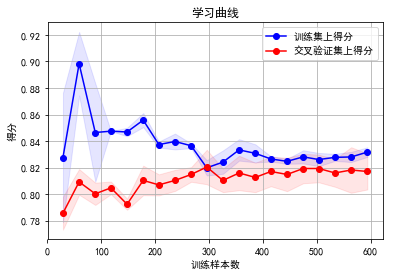

(0.8193924379212174, 0.03178834604130032)

In [371]:
from sklearn.model_selection import learning_curve

# 用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"训练样本数")
        plt.ylabel(u"得分")
        plt.gca().invert_yaxis()
        plt.grid()
    
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"训练集上得分")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"交叉验证集上得分")
    
        plt.legend(loc="best")
        
        plt.draw()
        plt.gca().invert_yaxis()
        plt.show()
    
    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

plot_learning_curve(clf, u"学习曲线", X, y)

In [372]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline

from sklearn.feature_selection import RFECV

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


#回归模型模块
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


#分类模型模块
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC, LinearSVC

from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

def Baseline(X,y):
    MLA=[AdaBoostClassifier(),BaggingClassifier(),ExtraTreesClassifier(),\
    GradientBoostingClassifier(),RandomForestClassifier(),\
    GaussianProcessClassifier(),LogisticRegressionCV(),\
    PassiveAggressiveClassifier(),SGDClassifier(),\
    Perceptron(),BernoulliNB(),GaussianNB(),KNeighborsClassifier(),\
    SVC(probability=True),LinearSVC(),DecisionTreeClassifier()]
    MLA_compare={}
    #确定一下随机数，这样能保证结果的可重复性
    for alg in MLA:
        alg.random_state=0
        MLA_name=alg.__class__.__name__
        score=cross_val_score(alg,X,y,cv=5)
        score_mean=round(score.mean(),4)
        MLA_compare[MLA_name]=score_mean
    scores=pd.Series(MLA_compare)
    return scores.sort_values(ascending=False)
    
Baseline(X,y)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Pro

GradientBoostingClassifier     0.8340
SVC                            0.8294
LinearSVC                      0.8227
ExtraTreesClassifier           0.8227
LogisticRegressionCV           0.8205
AdaBoostClassifier             0.8193
GaussianProcessClassifier      0.8149
BaggingClassifier              0.8116
DecisionTreeClassifier         0.8104
RandomForestClassifier         0.8104
KNeighborsClassifier           0.7969
GaussianNB                     0.7892
BernoulliNB                    0.7723
SGDClassifier                  0.6762
Perceptron                     0.6729
PassiveAggressiveClassifier    0.6403
dtype: float64

In [385]:
from sklearn.ensemble import BaggingRegressor

# fit到BaggingRegressor之中
clf1 = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
bagging_clf = BaggingRegressor(clf1, n_estimators=20, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagging_clf.fit(X, y)

predictions = bagging_clf.predict(data_test_dummies)

result = pd.DataFrame({'PassengerId':data_test['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})
result.to_csv("logistic_regression_bagging_predictions2.csv", index=False)
#0.7559 ...

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [384]:
GradientBoostingClassifier(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=array([0, 1, ..., 1, 0], dtype=int64),
              loss=array([[0, 0, ..., 0, 0],
       [1, 0, ..., 1, 0],
       ...,
       [1, 0, ..., 1, 0],
       [0, 0, ..., 0, 0]], dtype=uint8),
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)